In [1]:
import os
import pickle
from functools import reduce

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine
from plotnine import *

import anndata as ad
import scanpy as sc

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
from scipy.sparse import issparse, isspmatrix_csc, isspmatrix_csr

%matplotlib inline

import sys
sys.path.insert(0, "..")
from plot_settings import *
from utils import plot_gene_violin

numpy2ri.activate()
pandas2ri.activate()
%load_ext rpy2.ipython

In [2]:
adatas_raw = {}
for s in range(1,4):
    sample = sc.read_visium(f"../../spaceranger_output/2022-02/2022-02_Sample1-{s}/outs/")
    sample.var_names_make_unique()
    adatas_raw[f"1.{s}"] = sample

for s in range(1,5):
    sample = sc.read_visium(f"../../spaceranger_output/2022-02/2022-02_Sample2-{s}/outs/")
    sample.var_names_make_unique()
    adatas_raw[f"2.{s}"] = sample
    
for s in (1, 4):
    sample = sc.read_visium(f"../../spaceranger_output/2022-06/2022-06_Sample3-{s}/outs/")
    sample.var_names_make_unique()
    adatas_raw[f"3.{s}"] = sample

for s in range(1, 4):
    sample = sc.read_visium(f"../../spaceranger_output/2022-06/2022-06_Sample4-{s}/outs/")
    sample.var_names_make_unique()
    adatas_raw[f"4.{s}"] = sample
    
for s in range(2, 5):
    sample = sc.read_visium(f"../../spaceranger_output/2022-06/2022-06_Sample5-{s}/outs/")
    sample.var_names_make_unique()
    adatas_raw[f"5.{s}"] = sample

/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make 

In [3]:
del adatas_raw["2.3"]
del adatas_raw["4.2"]

In [4]:
genes = reduce(lambda x, y: x.intersection(y), (adata.var_names for adata in adatas_raw.values()))
df = []
for sname, adata in adatas_raw.items():
    df.append(pd.DataFrame(data=np.asarray(adata[:, genes].X.sum(0)), index=[sname], columns=genes))
df = pd.concat(df)

In [5]:
adata_vis = ad.read_h5ad("cell2location_results/cell2location_map/sp.h5ad")
celltypefractions = (
    adata_vis.obsm["q05_cell_abundance_w_sf"]
    .div(adata_vis.obsm["q05_cell_abundance_w_sf"].sum(1), axis=0)
    .assign(sample=adata_vis.obs["sample"])
    .set_index("sample", append=True)
)
celltypefractions.columns = celltypefractions.columns.str[23:]
malignant = celltypefractions.columns[
    celltypefractions.columns.str.startswith("Malignant")
]
malignantfractions = (
    celltypefractions[malignant]
    .sum(axis=1)
    .groupby("sample")
    .aggregate(np.mean)
    .reindex(df.index)
)

In [6]:
robjects.r.assign("mat", df.to_numpy().T)
robjects.r.assign("samples", df.index.to_numpy())
robjects.r.assign("genes", df.columns.to_numpy())
robjects.r.assign("malignantfractions", malignantfractions.to_numpy())

array([0.68182601, 0.64758079, 0.78354501, 0.71777174, 0.58558457,
       0.7085547 , 0.69182003, 0.75707098, 0.36650783, 0.55421061,
       0.71553345, 0.54939751, 0.61602006])

In [7]:
%%R
colnames(mat) <- samples
rownames(mat) <- genes

In [8]:
%%R
colData <- data.frame(type=rep("LFS", ncol(mat)), malignantfraction=malignantfractions, row.names=colnames(mat))
colData$type[startsWith(samples, "4") | startsWith(samples, "5")] <- "sporadic"
colData$type <- factor(colData$type)

In [9]:
%%R
library(DESeq2)
dds <- DESeqDataSetFromMatrix(countData=mat, colData=colData, design=~type + malignantfraction)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following object is masked from ‘package:utils’:

    findMatches


R[write to console]: The following 

In [10]:
%%R
dds <- DESeq(dds)
library(IHW)
res <- results(dds, contrast=c("type", "sporadic", "LFS"), filterFun=ihw)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



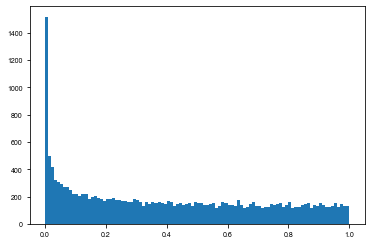

In [11]:
de = robjects.r("as.data.frame(res)")
plt.hist(de.pvalue, bins=100);

In [12]:
from IPython.display import display
with pd.option_context("display.max_rows", 3000):
    display(de[de.padj < 0.05].sort_values("log2FoldChange", ascending=False))

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight
NEUROG1,176.793124,6.782967,1.249266,5.429564,5.649178e-08,2.643104e-05,1.196703
GABRA6,194.299290,6.602989,1.608084,4.106123,4.023560e-05,2.644053e-03,1.261898
CYP11A1,148.111236,6.594899,0.978064,6.742812,1.553507e-11,3.150081e-08,1.262289
KLK4,378.589818,6.389118,1.304304,4.898489,9.657645e-07,2.332160e-04,1.196703
NKX2-5,24.325110,6.216862,1.669689,3.723364,1.965856e-04,8.135889e-03,1.251226
LHX9,456.734489,6.157771,1.691175,3.641121,2.714538e-04,1.013516e-02,1.196703
ISLR2,1655.188941,6.071532,1.107373,5.482824,4.185899e-08,2.174676e-05,1.149577
WSCD2,169.393385,6.049906,1.317619,4.591544,4.399790e-06,6.665307e-04,1.196703
ATP2B3,23.104454,5.987396,1.638679,3.653795,2.583928e-04,9.150394e-03,1.337456
TBX5,39.997343,5.906376,1.487783,3.969917,7.189754e-05,3.802181e-03,1.337456


/home/kats/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log10
/home/kats/.local/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 26 rows containing missing values.


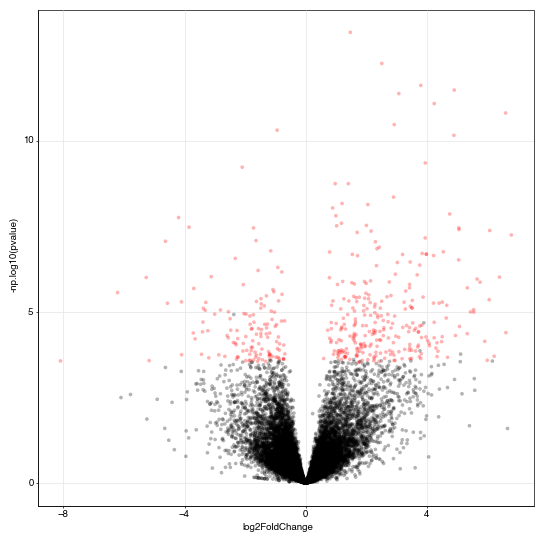

<ggplot: (8734185804248)>

In [13]:
(
    ggplot(de, aes("log2FoldChange", "-np.log10(pvalue)", color="padj < 0.01"))
    + geom_point(alpha=0.3, stroke=0)
    + scale_color_manual(values=["black", "red"], breaks=[False, True])
    + guides(color=None)
)

In [14]:
de.sort_values("log2FoldChange", ascending=False).reset_index(
    names=["gene"]
).to_csv("lfs_sporadic.csv", index=False)

In [15]:
for sample in adatas_raw.values():
    sample.layers["counts"] = sample.X.copy()
    sc.pp.normalize_total(sample, target_sum=1e4, key_added="scaling_factor")
    sc.pp.log1p(sample)

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_SOX2_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/ka

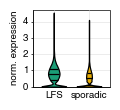

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_DUSP9_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/k

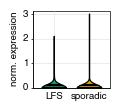

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_BEX1_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/ka

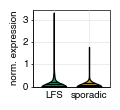

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_CCNA2_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/k

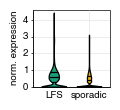

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_ROR2_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/ka

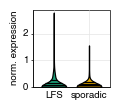

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_PVALB_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/k

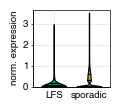

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_NEUROG1_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home

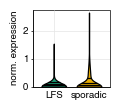

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_NPAS3_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/k

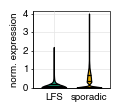

/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1 x 1 in image.
/home/kats/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/SX_KCNC2_violin_unfiltered.svgz
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/kats/.local/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/k

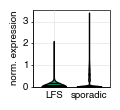

In [22]:
for gene in ("SOX2", "DUSP9", "BEX1", "CCNA2", "ROR2", "PVALB", "NEUROG1", "NPAS3", "KCNC2"):
    p = plot_gene_violin(adatas_raw, gene) + theme(figure_size=(1, 1))
    p.save(f"figures/SX_{gene}_violin_unfiltered.svgz")
    print(p)